The files we are using and what each one contributes:

Prevalence_of obesity_among_adults_WHO.csv

 - This file contains the features: ( Indicator_Code, Indicator, ValueType, ParentLocationCode, ParentLocation, LocationType, SpatialDimValueCode, Location, PeriodType, Period,
                                      isLatestYear,  Dim1_Type, Dim1, Dim1ValueCode, Dim2Type, Dim2, Dim2ValueCode, Dim3_Type, Dim3, Dim3ValueCode, DataSourceDimValueCode,
                                      DataSource, FactValueNumeric, FactValueUoM, FactValueNumericLowPrefix, FactValueNumericLow, FactValueNumericHighPrefix, FactValueNumericHigh,
                                      Value, FactValueTranslationID, FactComments, Language, DataModified )

The main important features that we will use are:
   
 - Fact_Value_Numeric: The actual numeric value for obesity prevalence

 - Fact_Value_Numeric_Low: the lowest possible value the true obesity rate might be.

 - Fact_Value_Numeric_High: The highest possible value true obesity rate might be.

   - Ex.) Fact_Value_Numeric = 27.3     Fact_Value_Numeric_Low = 25.8     Fact_Value_Numeric_High = 29.1
          This means the estimated obesity prevalence is 27.3%, but the true rate is likely between 25.8% and 29.1%.

 - Location: Which country it is in.

   - Ex.) Ethiopia, Yemen, Sri Lanka
  
 - Period: The year of the data

    - Ex.) 2022
  

The list of features I want to use for this dataset are: Location, Period, Fact_Value_Numeric, Fact_Value_Numeric_Low, and Fact_Value_Numeric_High

 - This allows me to know the Location, Year, and obesity prevalance data for each of the countries. We can pair this data up with other data about food consumption to develop a Predictor for obesity prevalance. WE can then play around with certain features to predict how much of a differenec it would make if a country ate just 500 less calories or walked 500 more steps a day.


## 1. Getting the Data

### Where we got our data:

We're using three main datasets for this project:

1. **BEFA58B_ALL_LATEST.csv** - WHO obesity data
   - This has obesity rates by country, year, sex, and age
   - Got it from the World Health Organization's Global Health Observatory

2. **daily-per-capita-fat-supply.csv** - Fat consumption data
   - Shows how many grams of fat people consume per day in each country
   - From the UN Food and Agriculture Organization (FAO)

3. **FoodBalanceSheets_E_All_Area_Groups.csv** - Detailed food data
   - Has tons of info about food supply, including processed foods, calories, protein, etc.
   - Also from FAO Food Balance Sheets

### What the columns mean:

**Obesity dataset:**
- DIM_TIME = year
- GEO_NAME_SHORT = country name
- DIM_SEX = male/female/both
- DIM_AGE = age group
- RATE_PER_100_N = the actual obesity percentage
- RATE_PER_100_NL and RATE_PER_100_NU = confidence interval bounds (lower and upper)

**Fat supply dataset:**
- Entity = country
- Code = country code (like USA, GBR, etc.)
- Year = year
- The really long column name = daily fat consumption in grams per person

**Food balance sheets:**
- Area = country or region
- Item = type of food (like cereals, meat, etc.)
- Element = what type of measurement (production, imports, food available, etc.)
- Y2010-Y2023 = the actual values for each year
- Columns ending in F = flags about data quality
- Columns ending in N = notes

In [11]:
# importing what we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# make plots look nice
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries loaded!")

All libraries loaded!


In [45]:
# now load the data
obesity_df = pd.read_csv('BEFA58B_ALL_LATEST.csv')
fat_df = pd.read_csv('daily-per-capita-fat-supply.csv')
food_df = pd.read_csv('FoodBalanceSheets_E_All_Area_Groups.csv')

print("Obesity data shape:", obesity_df.shape)
print("Fat supply data shape:", fat_df.shape)
print("Food balance data shape:", food_df.shape)

Obesity data shape: (20790, 16)
Fat supply data shape: (12817, 4)
Food balance data shape: (69006, 51)


In [14]:
# let's see what we're working with
print("Obesity data preview:")
obesity_df.head()

Obesity data preview:


,IND_ID,IND_CODE,IND_UUID,IND_PER_CODE,DIM_TIME,DIM_TIME_TYPE,DIM_GEO_CODE_M49,DIM_GEO_CODE_TYPE,DIM_PUBLISH_STATE_CODE,IND_NAME,GEO_NAME_SHORT,DIM_SEX,DIM_AGE,RATE_PER_100_N,RATE_PER_100_NL,RATE_PER_100_NU
0,BEFA58BNCD_BMI_30A,NCD_BMI_30A,BEFA58B,NCD_BMI_30A,1990,YEAR,288,COUNTRY,PUBLISHED,Obesity in adults (age 18+),Ghana,TOTAL,Y_GE18,2.923865,2.267023,3.722596
1,BEFA58BNCD_BMI_30A,NCD_BMI_30A,BEFA58B,NCD_BMI_30A,1990,YEAR,296,COUNTRY,PUBLISHED,Obesity in adults (age 18+),Kiribati,FEMALE,Y_GE18,35.615239,30.393529,41.237101
2,BEFA58BNCD_BMI_30A,NCD_BMI_30A,BEFA58B,NCD_BMI_30A,1990,YEAR,296,COUNTRY,PUBLISHED,Obesity in adults (age 18+),Kiribati,MALE,Y_GE18,25.662801,21.081577,30.551597
3,BEFA58BNCD_BMI_30A,NCD_BMI_30A,BEFA58B,NCD_BMI_30A,1990,YEAR,296,COUNTRY,PUBLISHED,Obesity in adults (age 18+),Kiribati,TOTAL,Y_GE18,30.880660,27.393150,34.601346
4,BEFA58BNCD_BMI_30A,NCD_BMI_30A,BEFA58B,NCD_BMI_30A,1990,YEAR,300,COUNTRY,PUBLISHED,Obesity in adults (age 18+),Greece,FEMALE,Y_GE18,19.299324,14.818227,24.082108


In [15]:
print("Fat supply data preview:")
fat_df.head()

Fat supply data preview:


,Entity,Code,Year,total__00002901__food_available_for_consumption__0684pc__grams_of_fat_per_day_per_capita
0,Afghanistan,AFG,1961,36.451218
1,Afghanistan,AFG,1962,36.560574
2,Afghanistan,AFG,1963,37.507850
3,Afghanistan,AFG,1964,37.889103
4,Afghanistan,AFG,1965,38.657166


In [16]:
print("Food balance data preview:")
food_df.head()

Food balance data preview:


,Area Code,Area Code (M49),Area,Item Code,Item Code (FBS),Item,Element Code,Element,Unit,Y2010,...,Y2020N,Y2021,Y2021F,Y2021N,Y2022,Y2022F,Y2022N,Y2023,Y2023F,Y2023N
0,5000,'001,World,2501,'S2501,Population,511,Total Population - Both sexes,1000 No,6.948575e+06,...,NaN,7.927332e+06,X,NaN,7.993956e+06,X,NaN,8.063887e+06,X,NaN
1,5000,'001,World,2901,'S2901,Grand Total,664,Food supply (kcal/capita/day),kcal/cap/d,2.825190e+03,...,NaN,2.974940e+03,E,NaN,2.997700e+03,E,NaN,3.016000e+03,E,NaN
2,5000,'001,World,2901,'S2901,Grand Total,661,Food supply (kcal),million Kcal,7.165322e+09,...,NaN,8.607916e+09,E,NaN,8.746665e+09,E,NaN,8.877042e+09,E,NaN
3,5000,'001,World,2901,'S2901,Grand Total,674,Protein supply quantity (g/capita/day),g/cap/d,8.481000e+01,...,NaN,9.091000e+01,E,NaN,9.182000e+01,E,NaN,9.247000e+01,E,NaN
4,5000,'001,World,2901,'S2901,Grand Total,671,Protein supply quantity (t),t,2.150928e+08,...,NaN,2.630374e+08,E,NaN,2.679195e+08,E,NaN,2.721794e+08,E,NaN


## 2. Data Cleaning

### 2.1 Missing Values

First thing we need to do is check for missing data and figure out what to do about it.

In [18]:
# check missing values in obesity data
print("Missing values in obesity dataset:")
print(obesity_df.isnull().sum())
print("\nPercentage missing:")
print((obesity_df.isnull().sum() / len(obesity_df)) * 100)

Missing values in obesity dataset:
IND_ID                    0
IND_CODE                  0
IND_UUID                  0
IND_PER_CODE              0
DIM_TIME                  0
DIM_TIME_TYPE             0
DIM_GEO_CODE_M49          0
DIM_GEO_CODE_TYPE         0
DIM_PUBLISH_STATE_CODE    0
IND_NAME                  0
GEO_NAME_SHORT            0
DIM_SEX                   0
DIM_AGE                   0
RATE_PER_100_N            0
RATE_PER_100_NL           0
RATE_PER_100_NU           0
dtype: int64

Percentage missing:
IND_ID                    0.0
IND_CODE                  0.0
IND_UUID                  0.0
IND_PER_CODE              0.0
DIM_TIME                  0.0
DIM_TIME_TYPE             0.0
DIM_GEO_CODE_M49          0.0
DIM_GEO_CODE_TYPE         0.0
DIM_PUBLISH_STATE_CODE    0.0
IND_NAME                  0.0
GEO_NAME_SHORT            0.0
DIM_SEX                   0.0
DIM_AGE                   0.0
RATE_PER_100_N            0.0
RATE_PER_100_NL           0.0
RATE_PER_100_NU           0.0
dty

In [19]:
# check missing values in fat supply data
print("Missing values in fat supply dataset:")
print(fat_df.isnull().sum())
print("\nPercentage missing:")
print((fat_df.isnull().sum() / len(fat_df)) * 100)

Missing values in fat supply dataset:
Entity                                                                                         0
Code                                                                                        2601
Year                                                                                           0
total__00002901__food_available_for_consumption__0684pc__grams_of_fat_per_day_per_capita       0
dtype: int64

Percentage missing:
Entity                                                                                       0.00000
Code                                                                                        20.29336
Year                                                                                         0.00000
total__00002901__food_available_for_consumption__0684pc__grams_of_fat_per_day_per_capita     0.00000
dtype: float64


In [20]:
# check missing values in food balance data
print("Missing values in food balance dataset (top 20):")
missing_food = food_df.isnull().sum().sort_values(ascending=False)
print(missing_food.head(20))

Missing values in food balance dataset (top 20):
Y2010N    69006
Y2012N    69006
Y2011N    69006
Y2018N    69006
Y2019N    69006
Y2020N    69006
Y2017N    69006
Y2016N    69006
Y2023N    69006
Y2022N    69006
Y2021N    69006
Y2014N    69006
Y2015N    69006
Y2013N    69006
Y2023      2860
Y2023F     2860
Y2022F     2758
Y2022      2758
Y2021      2417
Y2021F     2417
dtype: int64


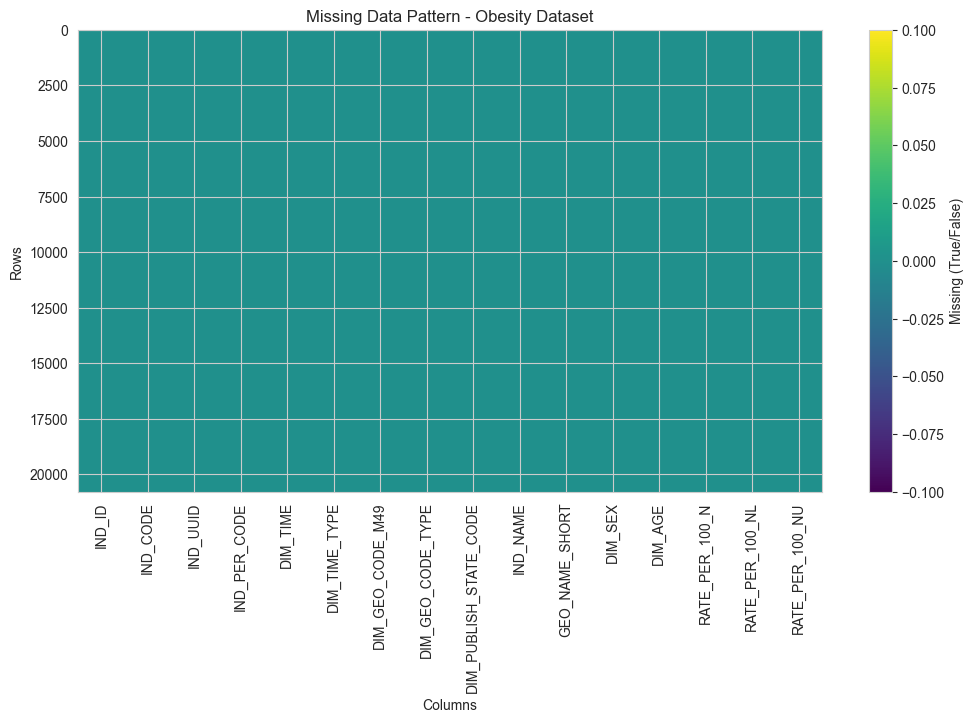

In [42]:
plt.figure(figsize=(12, 6))
plt.imshow(obesity_df.isnull(), aspect='auto', interpolation='nearest', cmap='viridis')
plt.title('Missing Data Pattern - Obesity Dataset')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.colorbar(label='Missing (True/False)')
plt.xticks(range(len(obesity_df.columns)), obesity_df.columns, rotation=90)
plt.show()


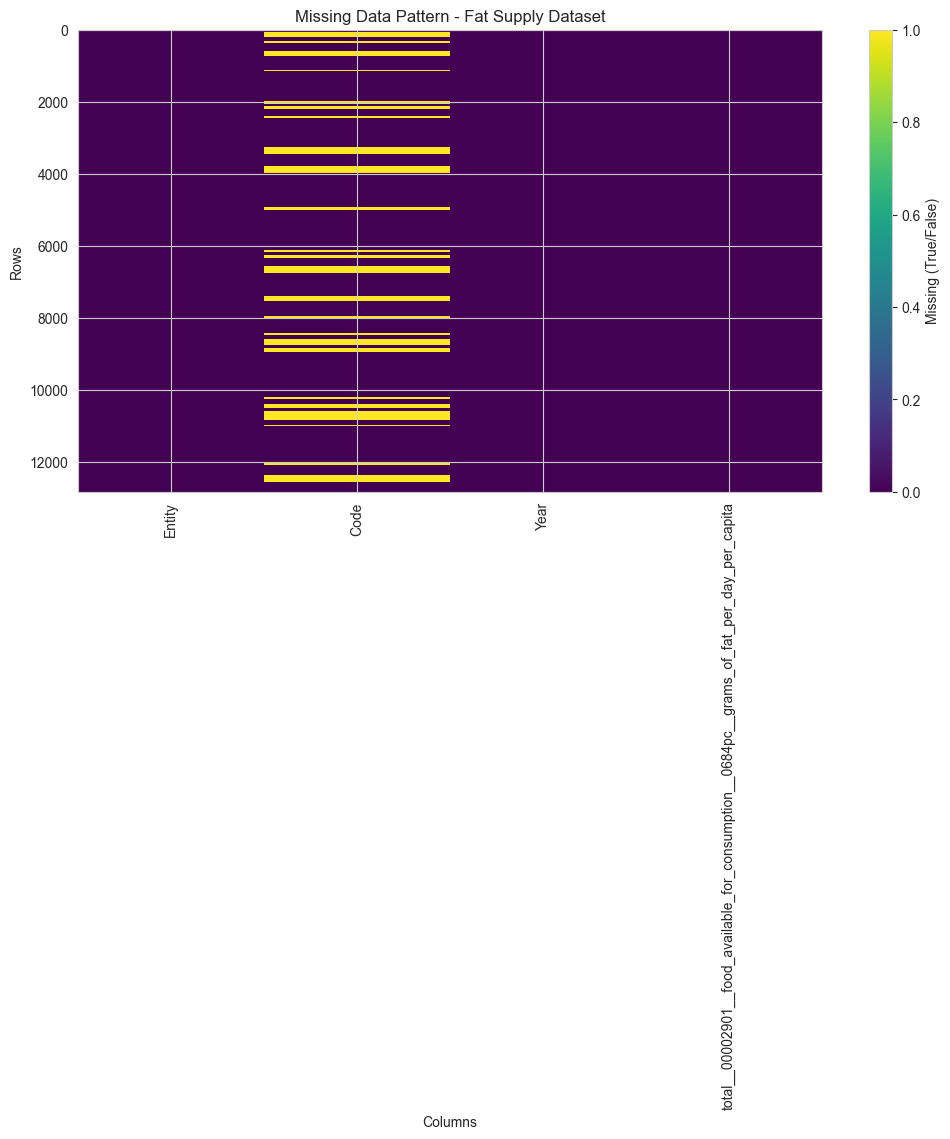

In [43]:
plt.figure(figsize=(12, 6))
plt.imshow(fat_df.isnull(), aspect='auto', interpolation='nearest', cmap='viridis')
plt.title('Missing Data Pattern - Fat Supply Dataset')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.colorbar(label='Missing (True/False)')
plt.xticks(range(len(fat_df.columns)), fat_df.columns, rotation=90)
plt.show()

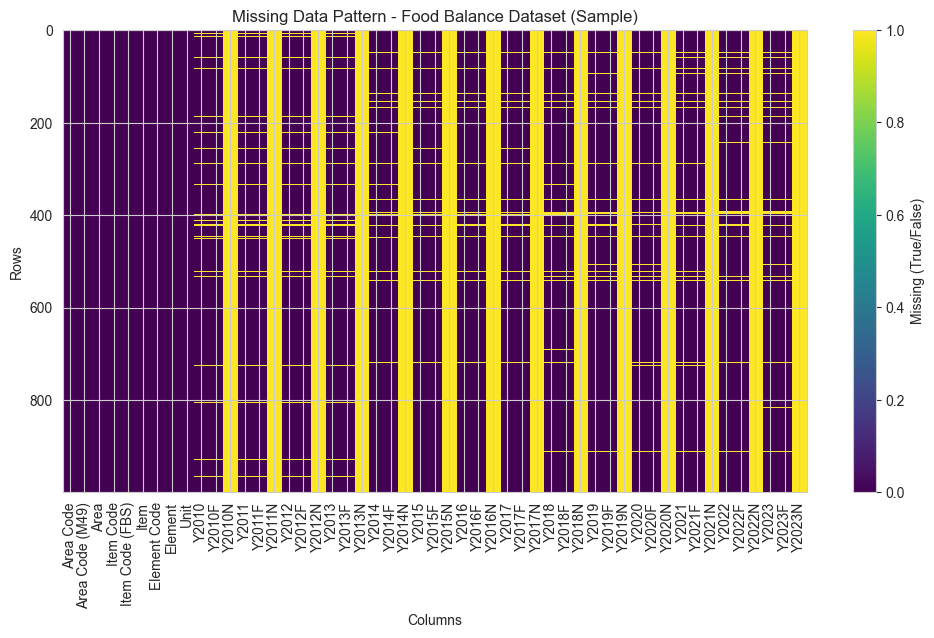

In [44]:
plt.figure(figsize=(12, 6))
plt.imshow(food_df.sample(1000).isnull(), aspect='auto', interpolation='nearest', cmap='viridis')
plt.title('Missing Data Pattern - Food Balance Dataset (Sample)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.colorbar(label='Missing (True/False)')
plt.xticks(range(len(food_df.columns)), food_df.columns, rotation=90)
plt.show()


#### Cleaning missing values

Okay so here's what we found:
- Obesity data looks pretty clean, no missing values
- Fat supply has some missing country codes and values
- Food balance sheets has a TON of missing data in the flag/note columns and some years

Our plan:
1. For obesity: nothing to do, it's good
2. For fat supply: drop rows without country codes (those are regional aggregates anyway) and without actual fat values (we need those)
3. For food balance: drop all those F and N columns (just metadata), and drop rows that are missing too much data

In [24]:
# obesity data is fine, just copy it
obesity_clean = obesity_df.copy()
print("Obesity data cleaned. Shape:", obesity_clean.shape)

Obesity data cleaned. Shape: (20790, 16)


In [25]:
# clean fat supply data
fat_clean = fat_df.copy()

# that column name is ridiculous, let's rename it
fat_clean.columns = ['Entity', 'Code', 'Year', 'Fat_Supply']

print("Before cleaning:", len(fat_clean))

# drop rows without country codes
fat_clean = fat_clean.dropna(subset=['Code'])
print("After dropping missing codes:", len(fat_clean))

# drop rows without fat supply values
fat_clean = fat_clean.dropna(subset=['Fat_Supply'])
print("After dropping missing fat values:", len(fat_clean))

Before cleaning: 12817
After dropping missing codes: 10216
After dropping missing fat values: 10216


In [26]:
# clean food balance data
food_clean = food_df.copy()

print("Before cleaning:", food_clean.shape)

# drop all those flag and note columns
cols_to_drop = [col for col in food_clean.columns if col.endswith('F') or col.endswith('N')]
print(f"Dropping {len(cols_to_drop)} flag/note columns")
food_clean = food_clean.drop(columns=cols_to_drop)

# find rows that are missing more than 50% of year data
year_cols = [col for col in food_clean.columns if col.startswith('Y')]
missing_pct = food_clean[year_cols].isnull().sum(axis=1) / len(year_cols)
food_clean = food_clean[missing_pct <= 0.5]

print("After cleaning:", food_clean.shape)

Before cleaning: (69006, 51)
Dropping 28 flag/note columns
After cleaning: (66734, 23)


**Why we did it this way:**

For the fat supply data, we removed rows without country codes because those are usually aggregated regions (like "World" or "Europe") that don't match up with our country-level obesity data. We also removed rows without fat values because that's literally our main predictor variable - can't do much without it.

For the food balance data, those F and N columns are just metadata about how the data was collected, not actual measurements. And we dropped rows with too much missing data because if a row is missing more than half its years, it's not going to be useful for seeing trends over time.

### 2.2 Outliers

Now let's check for outliers. These are extreme values that might mess up our analysis.

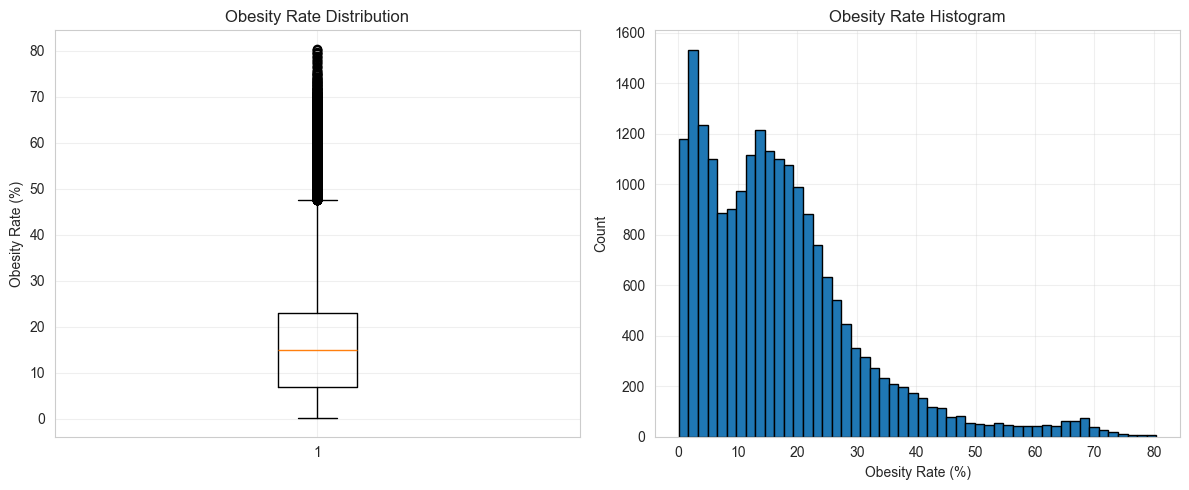

In [27]:
# look at obesity rate distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot(obesity_clean['RATE_PER_100_N'])
plt.ylabel('Obesity Rate (%)')
plt.title('Obesity Rate Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(obesity_clean['RATE_PER_100_N'], bins=50, edgecolor='black')
plt.xlabel('Obesity Rate (%)')
plt.ylabel('Count')
plt.title('Obesity Rate Histogram')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# calculate outliers using IQR method
Q1 = obesity_clean['RATE_PER_100_N'].quantile(0.25)
Q3 = obesity_clean['RATE_PER_100_N'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = obesity_clean[(obesity_clean['RATE_PER_100_N'] < lower) | 
                         (obesity_clean['RATE_PER_100_N'] > upper)]

print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower:.2f}")
print(f"Upper bound: {upper:.2f}")
print(f"\nNumber of outliers: {len(outliers)} out of {len(obesity_clean)} ({len(outliers)/len(obesity_clean)*100:.1f}%)")

Q1: 6.77
Q3: 23.05
IQR: 16.28
Lower bound: -17.65
Upper bound: 47.47

Number of outliers: 833 out of 20790 (4.0%)


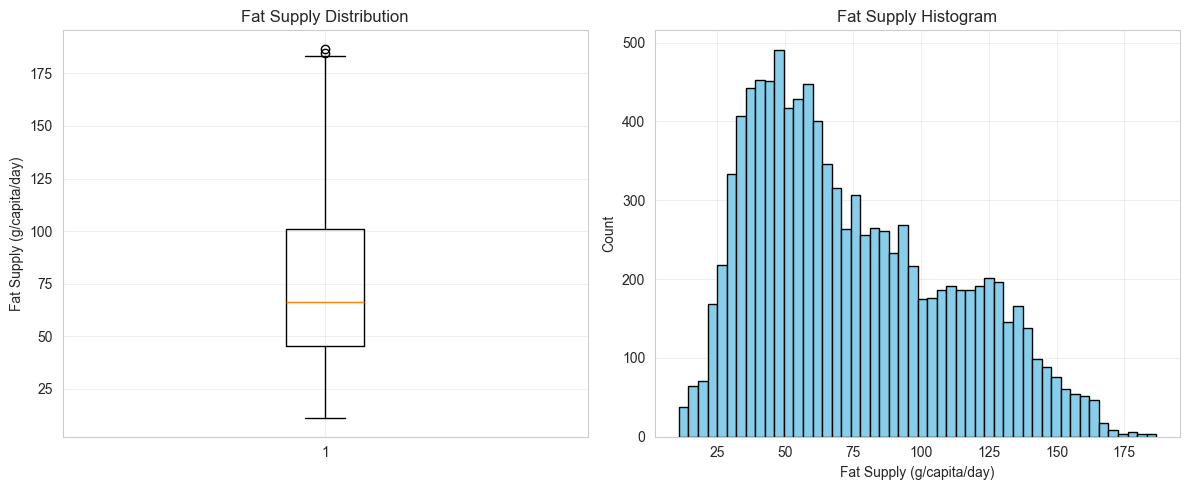

In [29]:
# look at fat supply distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot(fat_clean['Fat_Supply'])
plt.ylabel('Fat Supply (g/capita/day)')
plt.title('Fat Supply Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(fat_clean['Fat_Supply'], bins=50, edgecolor='black', color='skyblue')
plt.xlabel('Fat Supply (g/capita/day)')
plt.ylabel('Count')
plt.title('Fat Supply Histogram')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# calculate fat supply outliers
Q1_fat = fat_clean['Fat_Supply'].quantile(0.25)
Q3_fat = fat_clean['Fat_Supply'].quantile(0.75)
IQR_fat = Q3_fat - Q1_fat

lower_fat = Q1_fat - 1.5 * IQR_fat
upper_fat = Q3_fat + 1.5 * IQR_fat

outliers_fat = fat_clean[(fat_clean['Fat_Supply'] < lower_fat) | 
                         (fat_clean['Fat_Supply'] > upper_fat)]

print(f"Fat supply outliers: {len(outliers_fat)} ({len(outliers_fat)/len(fat_clean)*100:.1f}%)")
print(f"\nBasic stats:")
print(fat_clean['Fat_Supply'].describe())

Fat supply outliers: 2 (0.0%)

Basic stats:
count    10216.000000
mean        74.780878
std         36.303513
min         10.974196
25%         45.412312
50%         66.454955
75%        100.884033
max        186.676070
Name: Fat_Supply, dtype: float64


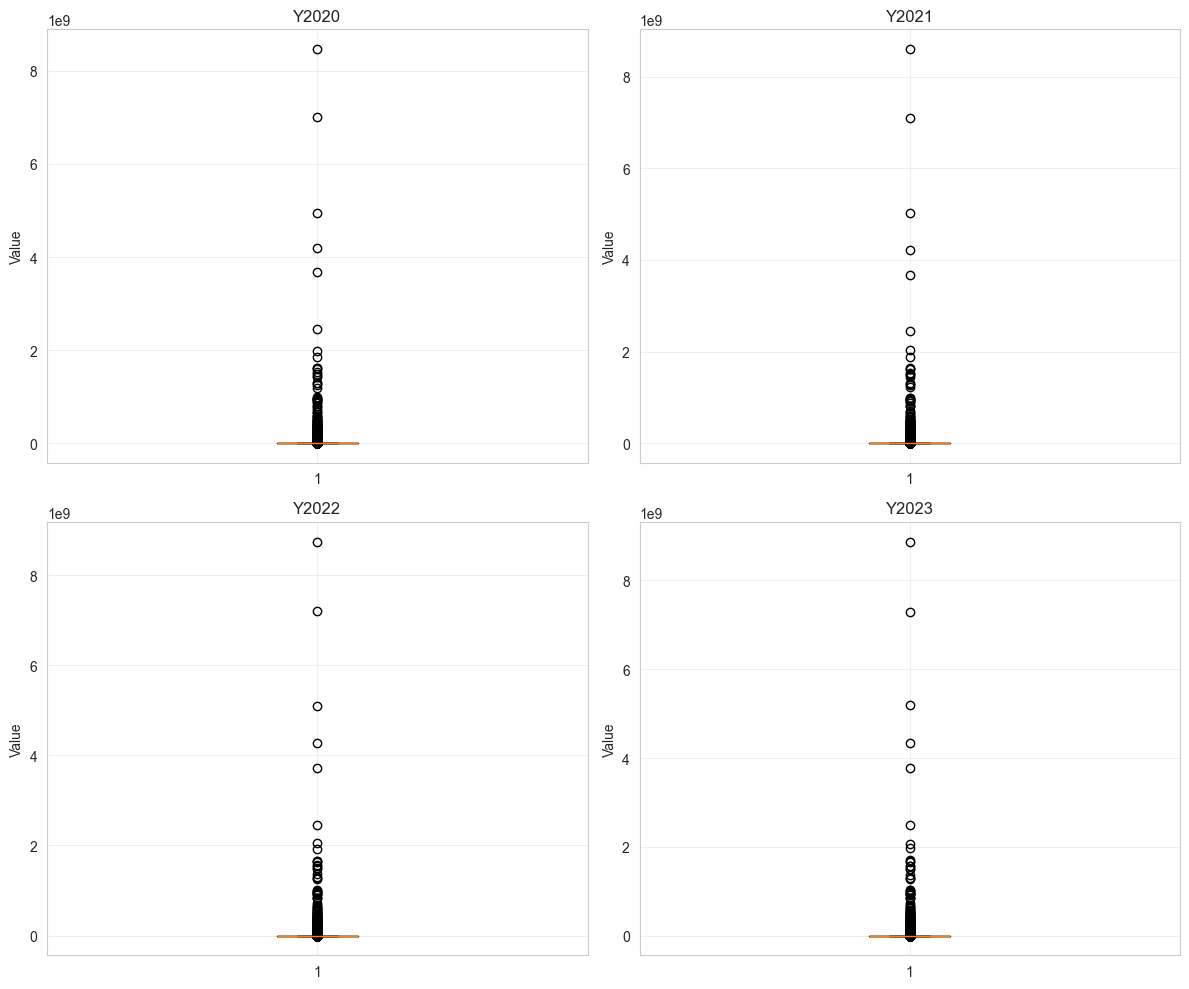

In [31]:
# check a few recent years from food balance data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

years = ['Y2020', 'Y2021', 'Y2022', 'Y2023']

for i, year in enumerate(years):
    if year in food_clean.columns:
        axes[i].boxplot(food_clean[year].dropna())
        axes[i].set_title(f'{year}')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### What to do about outliers

So we found some outliers, especially in the obesity rates (some countries have really high obesity) and fat supply (some countries eat way more or way less fat than average).

**Our decision: Keep them**

Why? Because these aren't data entry errors or mistakes - they're real. Some Pacific island countries genuinely have obesity rates over 50%. Some countries really do consume very little fat. These extreme cases are actually important for our research because we want to understand the full range of relationships between diet and obesity.

Plus, if we remove them, we'd be limiting our model to only "normal" cases, which isn't very useful if we want to make recommendations for countries at both ends of the spectrum.

In [32]:
# keep all data but flag the outliers so we can check them later if needed
fat_clean['is_outlier'] = ((fat_clean['Fat_Supply'] < lower_fat) | 
                           (fat_clean['Fat_Supply'] > upper_fat))

print(f"Flagged {fat_clean['is_outlier'].sum()} outliers in fat supply data")
print("Keeping all data points for analysis")

Flagged 2 outliers in fat supply data
Keeping all data points for analysis


### 2.3 Distribution Analysis

Need to check if our data is normally distributed or if it's skewed. This matters for some types of models.

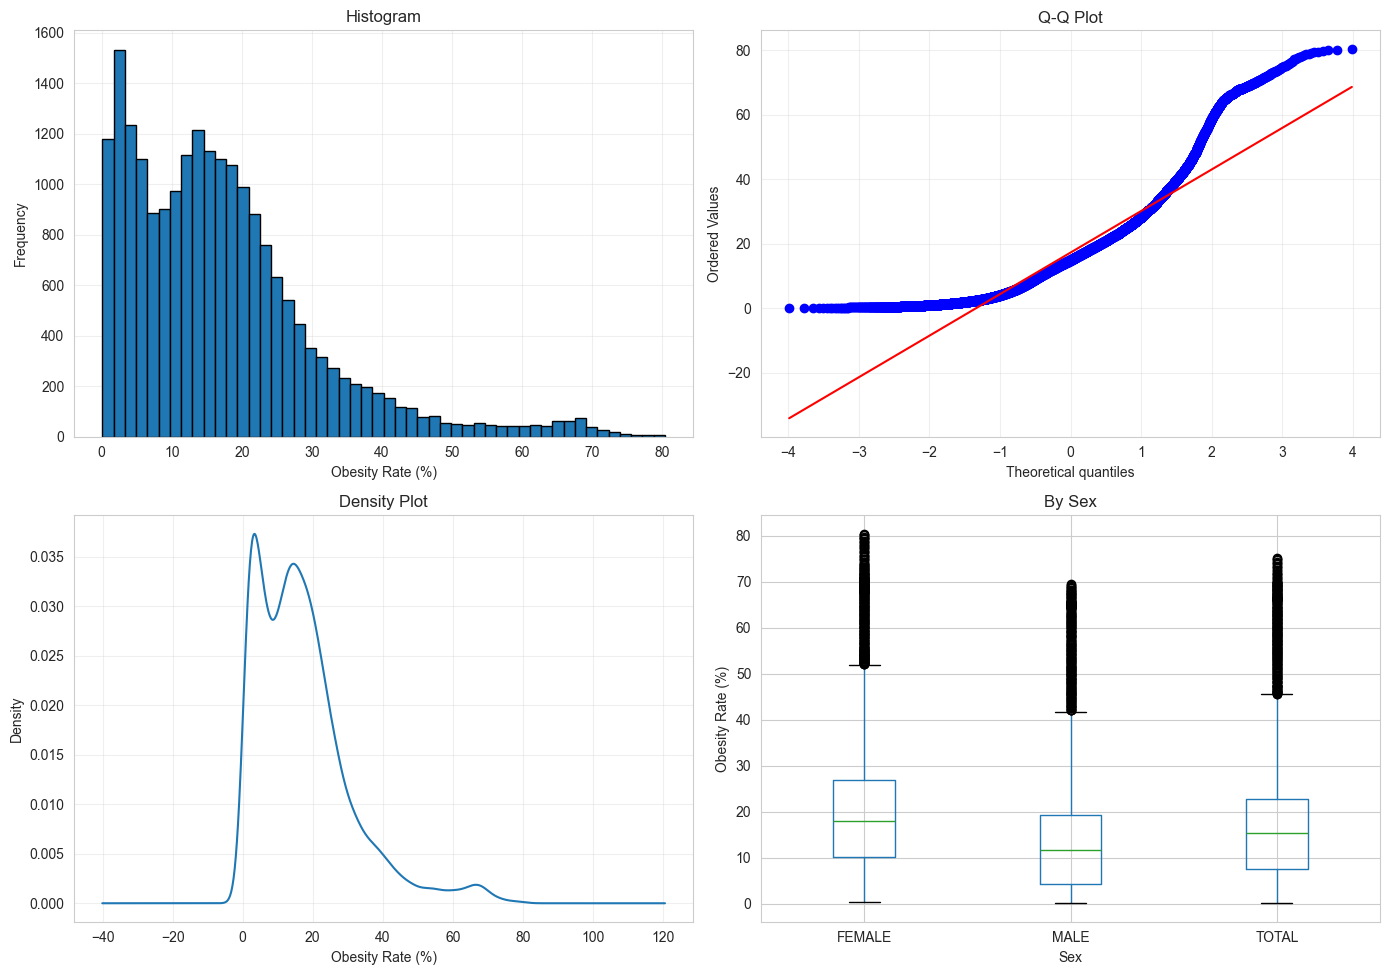

Skewness: 1.452
Distribution is right-skewed


In [33]:
# check obesity rate distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# histogram
axes[0, 0].hist(obesity_clean['RATE_PER_100_N'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Obesity Rate (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Histogram')
axes[0, 0].grid(True, alpha=0.3)

# Q-Q plot to check normality
stats.probplot(obesity_clean['RATE_PER_100_N'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')
axes[0, 1].grid(True, alpha=0.3)

# density plot
obesity_clean['RATE_PER_100_N'].plot(kind='density', ax=axes[1, 0])
axes[1, 0].set_xlabel('Obesity Rate (%)')
axes[1, 0].set_title('Density Plot')
axes[1, 0].grid(True, alpha=0.3)

# box plot by sex
obesity_clean.boxplot(column='RATE_PER_100_N', by='DIM_SEX', ax=axes[1, 1])
axes[1, 1].set_xlabel('Sex')
axes[1, 1].set_ylabel('Obesity Rate (%)')
axes[1, 1].set_title('By Sex')
plt.suptitle('')

plt.tight_layout()
plt.show()

# calculate skewness
obesity_skew = skew(obesity_clean['RATE_PER_100_N'])
print(f"Skewness: {obesity_skew:.3f}")
if abs(obesity_skew) < 0.5:
    print("Distribution is pretty symmetric")
elif obesity_skew > 0:
    print("Distribution is right-skewed")
else:
    print("Distribution is left-skewed")

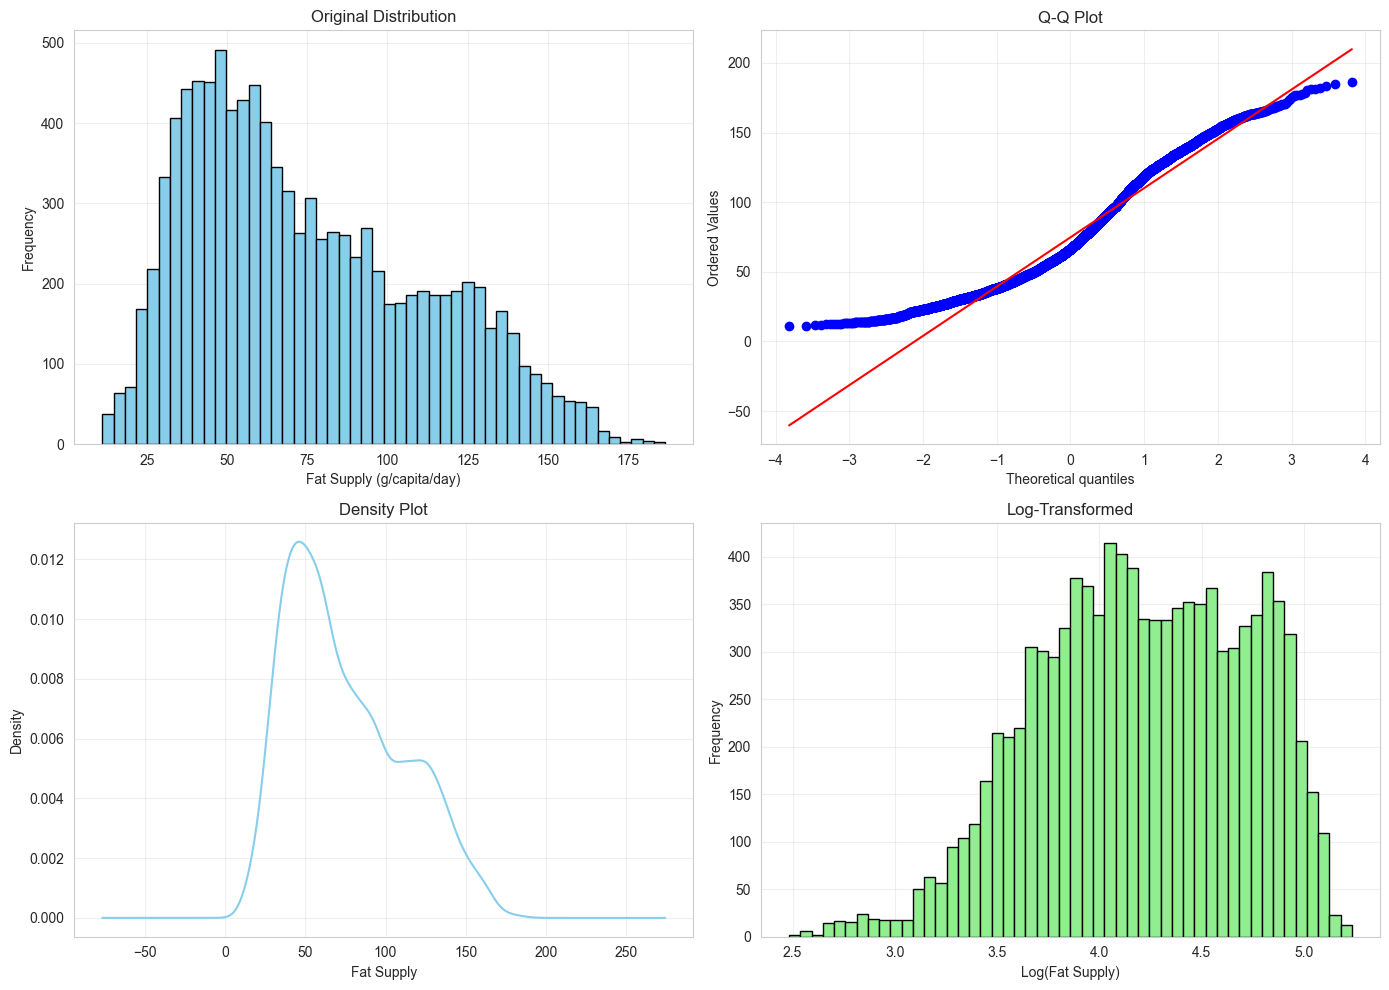

Original skewness: 0.571
Log-transformed skewness: -0.290


In [34]:
# check fat supply distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# original distribution
axes[0, 0].hist(fat_clean['Fat_Supply'], bins=50, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('Fat Supply (g/capita/day)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Original Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(fat_clean['Fat_Supply'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')
axes[0, 1].grid(True, alpha=0.3)

# density
fat_clean['Fat_Supply'].plot(kind='density', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_xlabel('Fat Supply')
axes[1, 0].set_title('Density Plot')
axes[1, 0].grid(True, alpha=0.3)

# log transformed version
log_fat = np.log1p(fat_clean['Fat_Supply'])
axes[1, 1].hist(log_fat, bins=50, edgecolor='black', color='lightgreen')
axes[1, 1].set_xlabel('Log(Fat Supply)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Log-Transformed')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fat_skew = skew(fat_clean['Fat_Supply'])
log_skew = skew(log_fat)
print(f"Original skewness: {fat_skew:.3f}")
print(f"Log-transformed skewness: {log_skew:.3f}")

#### Should we transform the data?

Looking at the skewness values:
- Obesity rates are pretty symmetric (skewness close to 0), so no need to transform
- Fat supply might be a bit skewed, but not terrible

We'll keep the original values for now because:
1. They're easier to interpret (people understand "grams of fat" better than "log grams of fat")
2. The skewness isn't extreme
3. Many ML models handle moderate skewness just fine

We can always transform later if our models need it.

### 2.4 Scaling

Different variables are on different scales (obesity % vs grams of fat vs calories). Some algorithms care about this, some don't.

In [35]:
# compare the scales
print("Obesity Rate stats:")
print(obesity_clean['RATE_PER_100_N'].describe())
print("\nFat Supply stats:")
print(fat_clean['Fat_Supply'].describe())

Obesity Rate stats:
count    20790.000000
mean        17.226901
std         13.689688
min          0.080571
25%          6.770937
50%         14.888305
75%         23.051640
max         80.390042
Name: RATE_PER_100_N, dtype: float64

Fat Supply stats:
count    10216.000000
mean        74.780878
std         36.303513
min         10.974196
25%         45.412312
50%         66.454955
75%        100.884033
max        186.676070
Name: Fat_Supply, dtype: float64


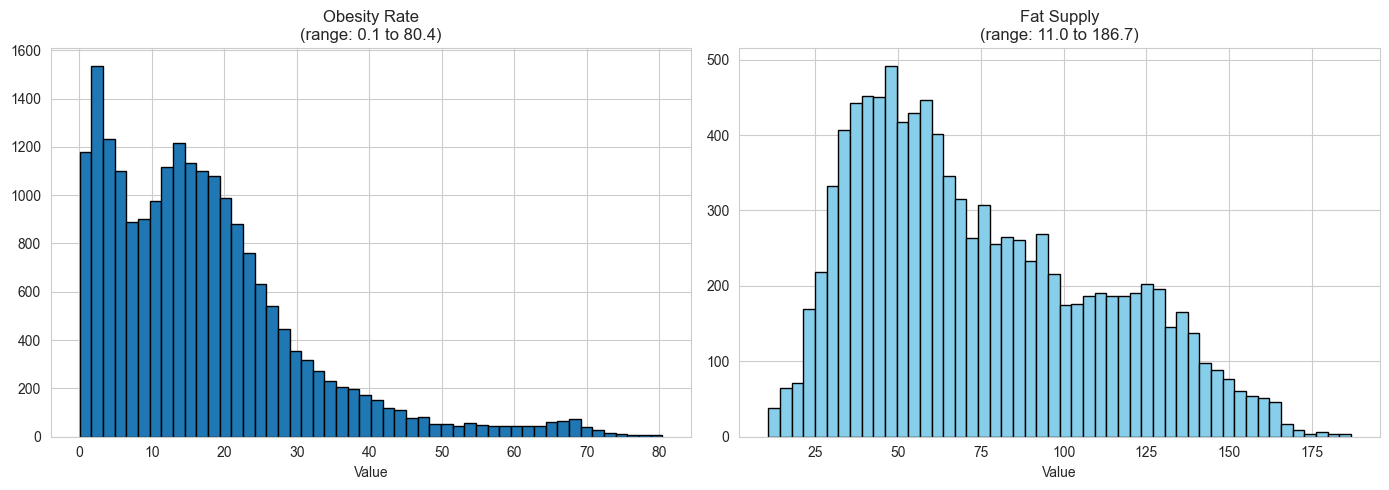

In [36]:
# visualize the different scales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(obesity_clean['RATE_PER_100_N'], bins=50, edgecolor='black')
axes[0].set_title(f'Obesity Rate\n(range: {obesity_clean["RATE_PER_100_N"].min():.1f} to {obesity_clean["RATE_PER_100_N"].max():.1f})')
axes[0].set_xlabel('Value')

axes[1].hist(fat_clean['Fat_Supply'], bins=50, edgecolor='black', color='skyblue')
axes[1].set_title(f'Fat Supply\n(range: {fat_clean["Fat_Supply"].min():.1f} to {fat_clean["Fat_Supply"].max():.1f})')
axes[1].set_xlabel('Value')

plt.tight_layout()
plt.show()

#### Scaling decision

We're NOT going to scale the data right now. Here's why:

It depends on what model we use:
- If we use linear regression, logistic regression, or neural networks → we'll need to scale
- If we use decision trees or random forests → scaling doesn't matter

Best practice is to scale as part of the modeling pipeline, not during data cleaning. That way:
1. We don't accidentally use test data info in our scaling (data leakage)
2. We can easily compare scaled vs unscaled models
3. We keep our cleaned data in interpretable units

When we do scale, we'll probably use StandardScaler (z-score normalization) because it's the most common and works well.

### 2.5 Relationships Between Variables

Let's merge our datasets and see how obesity relates to fat consumption.

In [37]:
# prepare obesity data for merging
# average by country and year since we have multiple age/sex groups
obesity_by_country = obesity_clean.groupby(['GEO_NAME_SHORT', 'DIM_TIME'])['RATE_PER_100_N'].mean().reset_index()
obesity_by_country.columns = ['Country', 'Year', 'Obesity_Rate']

# prepare fat data
fat_for_merge = fat_clean[['Entity', 'Year', 'Fat_Supply']].copy()
fat_for_merge.columns = ['Country', 'Year', 'Fat_Supply']

# merge them
merged = pd.merge(obesity_by_country, fat_for_merge, on=['Country', 'Year'], how='inner')

print(f"Merged dataset has {len(merged)} rows")
print(f"Covers {merged['Country'].nunique()} countries")
print(f"Years: {merged['Year'].min()} to {merged['Year'].max()}")
merged.head()

Merged dataset has 5029 rows
Covers 167 countries
Years: 1990 to 2022


,Country,Year,Obesity_Rate,Fat_Supply
0,Afghanistan,1990,1.947689,47.135670
1,Afghanistan,1991,2.102407,42.373604
2,Afghanistan,1992,2.269858,39.639732
3,Afghanistan,1993,2.451083,33.593197
4,Afghanistan,1994,2.647545,32.339440


Correlation matrix:
              Obesity_Rate  Fat_Supply
Obesity_Rate      1.000000    0.504877
Fat_Supply        0.504877    1.000000


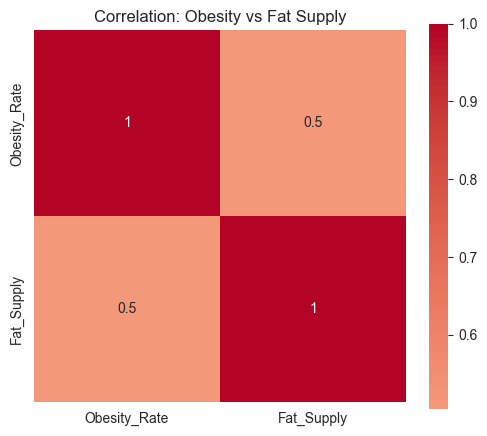

In [38]:
# calculate correlation
corr = merged[['Obesity_Rate', 'Fat_Supply']].corr()
print("Correlation matrix:")
print(corr)

# visualize correlation
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation: Obesity vs Fat Supply')
plt.show()

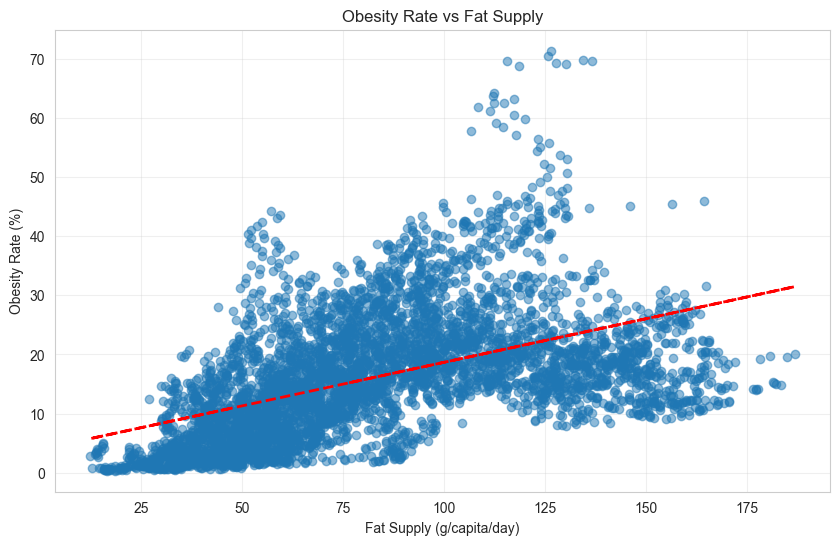

Looks like there's a positive relationship - more fat consumption = higher obesity


In [39]:
# scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged['Fat_Supply'], merged['Obesity_Rate'], alpha=0.5)

# add a trend line
z = np.polyfit(merged['Fat_Supply'], merged['Obesity_Rate'], 1)
p = np.poly1d(z)
plt.plot(merged['Fat_Supply'], p(merged['Fat_Supply']), "r--", linewidth=2)

plt.xlabel('Fat Supply (g/capita/day)')
plt.ylabel('Obesity Rate (%)')
plt.title('Obesity Rate vs Fat Supply')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Looks like there's a positive relationship - more fat consumption = higher obesity")

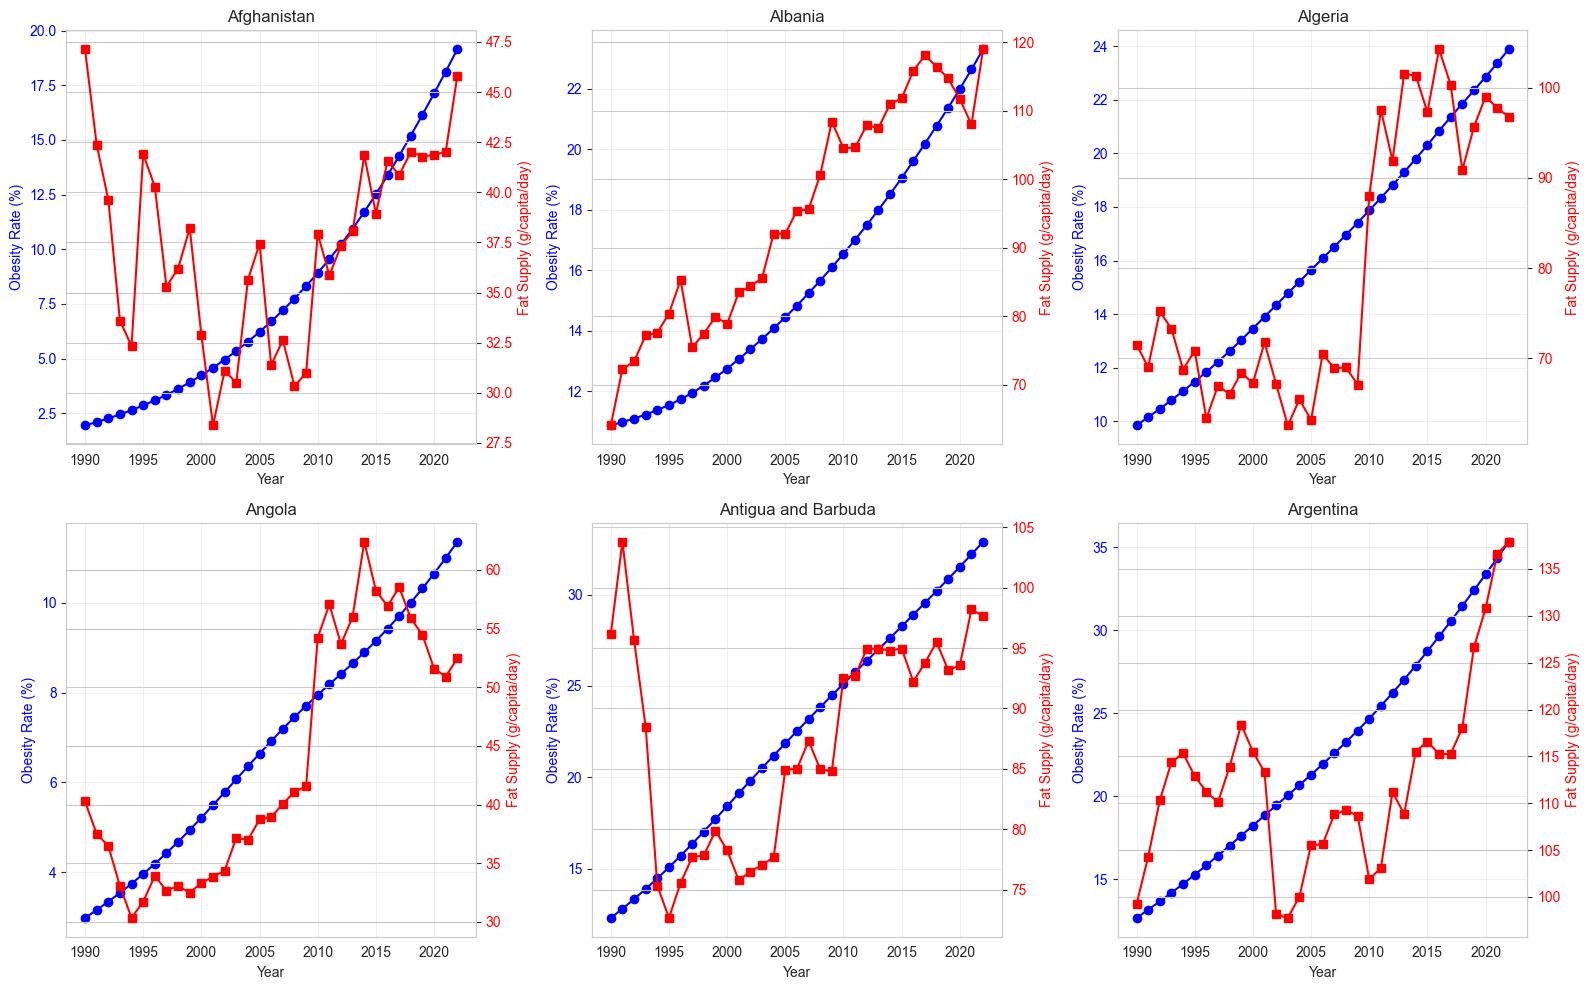

In [40]:
# look at trends over time for a few countries
# pick countries with most data points
top_countries = merged['Country'].value_counts().head(6).index

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, country in enumerate(top_countries):
    country_data = merged[merged['Country'] == country].sort_values('Year')
    
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # plot obesity on left axis
    ax1.plot(country_data['Year'], country_data['Obesity_Rate'], 'b-o', label='Obesity Rate')
    ax1.set_ylabel('Obesity Rate (%)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # plot fat supply on right axis
    ax2.plot(country_data['Year'], country_data['Fat_Supply'], 'r-s', label='Fat Supply')
    ax2.set_ylabel('Fat Supply (g/capita/day)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax1.set_xlabel('Year')
    ax1.set_title(country)
    ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Summary

### What we did:

1. **Loaded and explored three datasets** about obesity, fat consumption, and food balance

2. **Cleaned missing values:**
   - Obesity data was already clean
   - Dropped rows without country codes or fat values from fat supply data
   - Removed metadata columns and sparse rows from food balance data

3. **Handled outliers:**
   - Kept all outliers because they represent real data, not errors
   - Flagged them for potential sensitivity analysis later

4. **Analyzed distributions:**
   - Obesity rates are fairly symmetric
   - Fat supply has moderate skewness but not extreme
   - Decided not to transform for now

5. **Decided on scaling:**
   - Will scale during modeling if needed, not during cleaning
   - Avoids data leakage and keeps data interpretable

6. **Explored relationships:**
   - Found positive correlation between fat supply and obesity
   - Merged datasets successfully
   - Observed different trends across countries

### Next steps:

- Pick specific features from the food balance dataset (processed foods, calories, protein, etc.)
- Do more detailed feature engineering
- Build some models to predict obesity rates
- See which dietary factors matter most

In [41]:
# save the cleaned data
obesity_clean.to_csv('obesity_cleaned.csv', index=False)
fat_clean.to_csv('fat_supply_cleaned.csv', index=False)
food_clean.to_csv('food_balance_cleaned.csv', index=False)
merged.to_csv('merged_data_cleaned.csv', index=False)

print("Saved all cleaned datasets!")
print("Files:")
print("- obesity_cleaned.csv")
print("- fat_supply_cleaned.csv")
print("- food_balance_cleaned.csv")
print("- merged_data_cleaned.csv")

Saved all cleaned datasets!
Files:
- obesity_cleaned.csv
- fat_supply_cleaned.csv
- food_balance_cleaned.csv
- merged_data_cleaned.csv
